In [1]:
!pip install geopandas
!pip install rasterio
!pip install gdal
!pip install rasterstats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 4.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd
import osgeo.gdal as gdal
import os
import rasterio as rio
from rasterstats import zonal_stats
from rasterio.plot import show
from mpl_toolkits.axes_grid1 import make_axes_locatable

**Load data**

ERROR:fiona._env:fread(943) failed on DBF file.


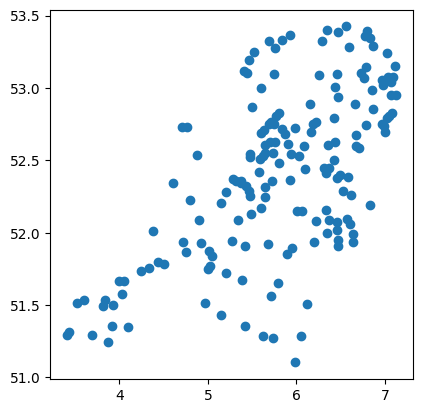

In [3]:
points_top_Soil = gpd.read_file('LUCAS_Topsoil_2015_20200323.shp')
NLD_boundaries = gpd.read_file('gadm36_NLD_0.shp')

# Select by location based on the boundaries of the Netherlands
polygon_NLD = NLD_boundaries.geometry[0]
points_NLD = points_top_Soil[points_top_Soil.within(polygon_NLD)]
points_NLD.plot()
folder_path = "top_soil_NLD"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

file_path = os.path.join(folder_path, 'top_soil_NLD.shp')
points_NLD.to_file(file_path)

In [4]:
NLD_boundaries_28992 = NLD_boundaries.to_crs('28992')

**Interpolation**

In [8]:
interpolated_clay = gdal.Grid('top_soil_NLD/interpolated_clay.tiff', 'top_soil_NLD/top_soil_NLD.shp', zfield='Clay', algorithm = 'linear:radius=0')
interpolated_sand = gdal.Grid('top_soil_NLD/interpolated_sand.tiff', 'top_soil_NLD/top_soil_NLD.shp', zfield='Sand', algorithm = 'linear:radius=0')
interpolated_silt = gdal.Grid('top_soil_NLD/interpolated_silt.tiff', 'top_soil_NLD/top_soil_NLD.shp', zfield='Silt', algorithm = 'linear:radius=0')


In [9]:
# Function for Reprojection
def Reprojecting_raster(file_path, output_path):
    input_raster = gdal.Open(file_path)
    warp = gdal.Warp(output_path, input_raster, dstSRS='EPSG:28992')
    warp = None

    return output_path

reprojected_folder_path = "top_soil_NLD_reproject"

if not os.path.exists(reprojected_folder_path):
    os.makedirs(reprojected_folder_path)

interpolated_clay_28992 = Reprojecting_raster('top_soil_NLD/interpolated_clay.tiff', 'top_soil_NLD_reproject/interpolated_clay_28992.tiff')
interpolated_sand_28992 = Reprojecting_raster('top_soil_NLD/interpolated_sand.tiff', 'top_soil_NLD_reproject/interpolated_sand_28992.tiff')
interpolated_silt_28992 = Reprojecting_raster('top_soil_NLD/interpolated_silt.tiff', 'top_soil_NLD_reproject/interpolated_silt_28992.tiff')

In [11]:
images = []
arrays_table= []
dir_tif_images = "top_soil_NLD_reproject"

for i in os.listdir(dir_tif_images):
  if i.endswith(".tiff"):
    path_file= os.path.join(dir_tif_images, i)
    file = rio.open(path_file)
    mask_file = file.read_masks(1)
    data_mask = np.ma.masked_array(file.read(1), mask_file==0)
    images.append(file)
    arrays_table.append(data_mask)

**Plot**

Text(-0.35, -0.1, 'Soil content')

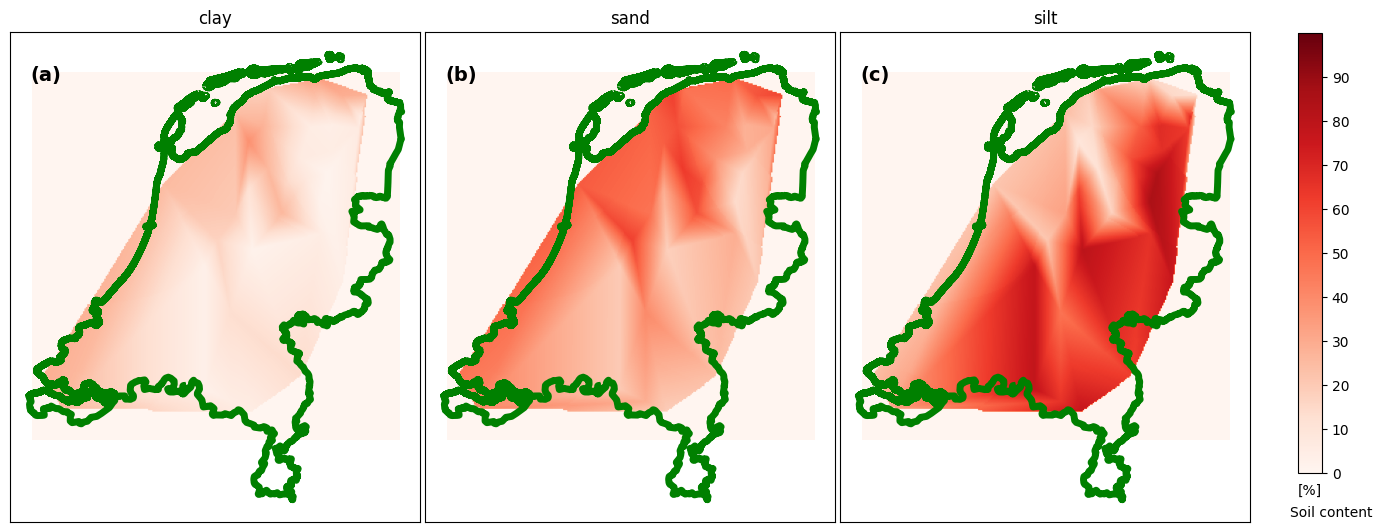

In [12]:
fig, axs = plt.subplots(1,3,figsize=(16,8))
labels_font = {'size':'14', 'weight':'bold'}

fig.subplots_adjust(hspace = .15, wspace=.011)
soil_types = ['clay', 'sand', 'silt']
letters = ['a','b', 'c']
axs = axs.ravel()

for i in range(3):
    rio.plot.show(images[i], ax=axs[i],  cmap='Reds', vmin=0, vmax=100)
    # axs[i].invert_yaxis()
    NLD_boundaries_28992.plot(ax=axs[i], facecolor='none', edgecolor='green', linewidth=5)
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].set_title(soil_types[i])
    axs[i].text(0.05, 0.9, '('+str(letters[i])+')', **labels_font, transform=axs[i].transAxes)

# Plotling the colorbar
# cbar_ax = fig.add_axes([0.93, 0.25, 0.015, 0.55])
# sm = plt.cm.ScalarMappable(cmap='Reds')
# colorbar = fig.colorbar(sm, cax=cbar_ax, ticks=range(0,1), boundaries=np.arange(0, 90), fraction=0.049)#
# colorbar.set_ticks(np.arange(0, 100, 10));
# plt.text(0, -0.05, '[%]', transform=cbar_ax.transAxes);
# plt.text(-0.35, -0.10, 'Soil content', transform=cbar_ax.transAxes)


cbar_ax = fig.add_axes([0.93, 0.25, 0.015, 0.55])
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=100))
sm._A = []  # Fake empty array for the colorbar
colorbar = fig.colorbar(sm, cax=cbar_ax, ticks=np.arange(0, 100, 10), fraction=0.049)
# cbar_ax.set_ylabel('[%]')
plt.text(0, -0.05, '[%]', transform=cbar_ax.transAxes);

plt.text(-0.35, -0.10, 'Soil content', transform=cbar_ax.transAxes)


**Loading basins**

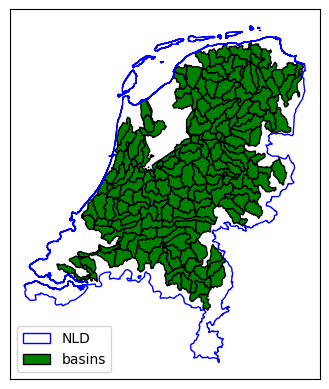

In [13]:
basins_NLD = gpd.read_file('basins_NLD_within.shp')
import matplotlib.patches as mpatches
LegendElement = [
                 mpatches.Patch(facecolor='None', edgecolor='blue', label='NLD'),
                 mpatches.Patch(facecolor='green', edgecolor='black', label='basins')]

fig, ax  = plt.subplots()
basins_NLD.plot(facecolor='green', edgecolor='black', ax=ax)
NLD_boundaries.plot(facecolor='None', edgecolor='blue', ax=ax)
ax.legend(handles = LegendElement, loc='lower left')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_xticks([]);

In [14]:
basins_NLD.head()

,HYBAS_ID,NEXT_DOWN,NEXT_SINK,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,PFAF_ID,ENDO,COAST,ORDER,SORT,geometry
0,2120023330,0,2120023330,2120023330,0.0,0.0,4.2,4.2,232703010110,0,1,0,34368,"POLYGON ((5.64583 52.61667, 5.64548 52.61909, ..."
1,2120366900,2120367860,2120023220,2120023220,11.9,11.9,118.4,307.6,232701040710,0,0,1,34256,"POLYGON ((4.76250 52.56250, 4.76307 52.56471, ..."
2,2120367860,2120367980,2120023220,2120023220,5.4,5.4,30.8,547.7,232701040500,0,0,1,34255,"POLYGON ((4.90417 52.38333, 4.90000 52.38333, ..."
3,2120368080,2120367980,2120023220,2120023220,5.3,5.3,117.2,117.2,232701040400,0,0,2,34254,"POLYGON ((4.90000 52.37917, 4.90242 52.37881, ..."
4,2120367870,2120023220,2120023220,2120023220,4.4,4.4,114.5,114.5,232701040200,0,0,2,34253,"POLYGON ((5.00000 52.57500, 5.00066 52.56763, ..."


In [15]:
basins_NLD_28992 = basins_NLD.to_crs('28992')

**Zonal Stats**

In [16]:
raster_folder = "top_soil_NLD_reproject/"
output_folder = "zonal_stats_folder"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

raster_files = [f for f in os.listdir(raster_folder) if f.endswith('.tiff')]

# Initialize an empty DataFrame to store the combined results
combined_df = pd.DataFrame()

for raster_file in raster_files:
    raster_path = os.path.join(raster_folder, raster_file)

    # Extract the variable name from the raster file name
    variable_name = os.path.splitext(raster_file)[0]

    # Perform zonal statistics
    zonal_stats_result = zonal_stats(basins_NLD_28992, raster_path, stats="mean")

    # Extract mean values
    mean_list = [feature['mean'] for feature in zonal_stats_result]

    # Create a DataFrame for the current variable
    variable_df = pd.DataFrame(mean_list, columns=[f'{variable_name}_mean'])

    # Append the results to the combined DataFrame
    combined_df = pd.concat([combined_df, variable_df], axis=1)

    print(f'Zonal statistics for {variable_name} appended to the combined DataFrame')

# Save the combined results to a CSV file
combined_output_path = os.path.join(output_folder, 'combined_zonal_stats.csv')
combined_df.to_csv(combined_output_path, index=False)

print(f'Combined zonal statistics saved to {combined_output_path}')


/usr/local/lib/python3.10/dist-packages/rasterstats/io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


Zonal statistics for interpolated_clay_28992 appended to the combined DataFrame
Zonal statistics for interpolated_silt_28992 appended to the combined DataFrame
Zonal statistics for interpolated_sand_28992 appended to the combined DataFrame
Combined zonal statistics saved to zonal_stats_folder/combined_zonal_stats.csv


In [17]:
combined_df.head()

,interpolated_clay_28992_mean,interpolated_silt_28992_mean,interpolated_sand_28992_mean
0,11.693848,31.037694,57.268459
1,17.865704,41.799983,40.334313
2,14.578821,37.180468,48.240711
3,11.744233,32.476478,55.779290
4,16.263251,43.567335,40.007026


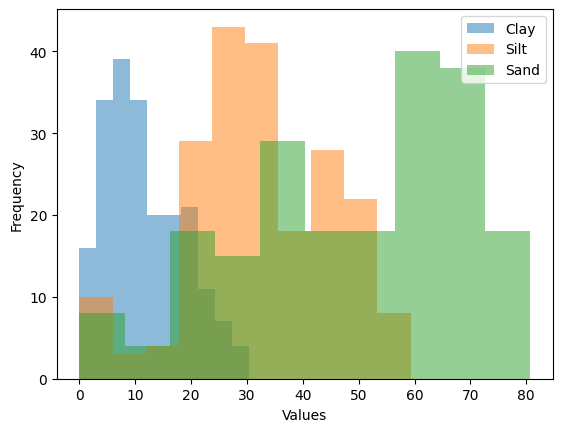

In [18]:
plt.hist(combined_df.interpolated_clay_28992_mean, alpha=0.5, label='Clay');
plt.hist(combined_df.interpolated_silt_28992_mean, alpha=0.5, label='Silt');
plt.hist(combined_df.interpolated_sand_28992_mean, alpha=0.5, label='Sand');
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.legend()

# Display the plot
plt.show()